# Wine Classification (Red vs White) - Problem Framing


## Context
Using the UCI Wine Quality dataset (Portuguese Vinho Verde, 2004-2007), we're building a binary classifier to distinguish red from white wines based on 11 physicochemical properties. Why? Because chemistry reveals patterns invisible to the eye, and automated classification has real applications in quality control, inventory management, and fraud detection.

## Why This Matters
- **Quality Control**: Rapid verification without tasting every batch
- **Education**: Teaching classification concepts with interpretable features
- **Consumer Transparency**: Understanding what makes wines chemically distinct

In [25]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

# Version check for reproducibility
print("Environment:")
print(f"Python: {sys.version.split()[0]}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")

Environment:
Python: 3.12.7
pandas: 2.3.3
numpy: 1.26.4
scikit-learn: 1.7.2
matplotlib: 3.10.6
seaborn: 0.13.2


## Problem Definition

### The Task
**Binary classification**: Given 11 chemical measurements, predict wine type (red=0, white=1).

### Five-Part Specification
**Predict whether** a wine sample **is** red or white **at** testing time **using** laboratory chemistry **to enable** automated quality control.

- **Decision**: Wine type (binary)
- **Unit**: Individual wine sample
- **Horizon**: Immediate (at chemical analysis)
- **Evidence**: pH, alcohol, sulfur dioxide, acidity, etc.
- **Action**: Route to appropriate storage/processing

## 2. Business Context & Stakeholders

### Primary Stakeholders
- **Wine Producers**: Need rapid quality assessment
- **Quality Control Teams**: Require consistent classification
- **Inventory Managers**: Need accurate sorting

### Impact Assessment
- **Benefits**: Automated sorting, reduced labor costs, consistent quality
- **Risks**: Misclassification could affect pricing and customer satisfaction

## Stakeholders & Impact

### Who Benefits
- **QC Teams**: Faster batch verification, reduced manual testing
- **Educators**: Clean dataset for teaching classification fundamentals
- **Data Practitioners**: Benchmark for testing new algorithms

### Limitations We Acknowledge
- **Chemistry ≠ Taste**: We classify type, not quality or preference
- **Regional Bias**: Portuguese wines only - may not generalize globally
- **Static Snapshot**: 2004-2007 data, wine chemistry evolves with climate

### Ethics & Sustainability
- **Bias**: Model trained on one region's wines could misclassify others
- **Environmental**: Automated testing reduces chemical waste, but consider compute costs
- **Transport**: Better classification could optimize shipping (reds/whites have different storage needs)

In [26]:
# Load datasets
red_wine = pd.read_csv('../data/winequality-red.csv', delimiter=';')
white_wine = pd.read_csv('../data/winequality-white.csv', delimiter=';')

# Add wine type labels
red_wine['wine_type'] = 0  # Red
white_wine['wine_type'] = 1  # White

# Combine datasets
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)

print(f"Dataset shape: {wine_data.shape}")
print(f"Red wines: {len(red_wine)} samples ({len(red_wine)/len(wine_data)*100:.1f}%)")
print(f"White wines: {len(white_wine)} samples ({len(white_wine)/len(wine_data)*100:.1f}%)")

Dataset shape: (6497, 13)
Red wines: 1599 samples (24.6%)
White wines: 4898 samples (75.4%)


## Data Source & License

**Data source & license.** UCI Machine Learning Repository - *Wine Quality* (Cortez et al., 2009), Vinho Verde (Portugal), 2004–2007.
Laboratory physicochemical measurements + expert "quality" scores.  
Use per UCI terms; redistribute CSVs for research/education.

In [27]:
# Display first few rows
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [28]:
# Check data types and missing values
print("Data Info:")
print(wine_data.info())
print("\nMissing values:")
print(wine_data.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB
None

Missing values:
fixed acidity           0
volatile acidity

## 4. Feature Overview

### Physicochemical Properties
- **Acidity measures**: fixed acidity, volatile acidity, citric acid
- **Sugar & density**: residual sugar, density
- **Sulfur compounds**: free/total sulfur dioxide
- **Other**: pH, sulphates, alcohol, chlorides

In [29]:
# Feature statistics by wine type
feature_cols = wine_data.columns[:-1]  # Exclude wine_type
comparison = wine_data.groupby('wine_type')[feature_cols].mean().T
comparison.columns = ['Red Wine', 'White Wine']
comparison['Difference'] = comparison['White Wine'] - comparison['Red Wine']
comparison.round(3)

,Red Wine,White Wine,Difference
fixed acidity,8.320,6.855,-1.465
volatile acidity,0.528,0.278,-0.250
citric acid,0.271,0.334,0.063
residual sugar,2.539,6.391,3.853
chlorides,0.087,0.046,-0.042
free sulfur dioxide,15.875,35.308,19.433
total sulfur dioxide,46.468,138.361,91.893
density,0.997,0.994,-0.003
pH,3.311,3.188,-0.123
sulphates,0.658,0.490,-0.168


## 5. Class Balance Analysis

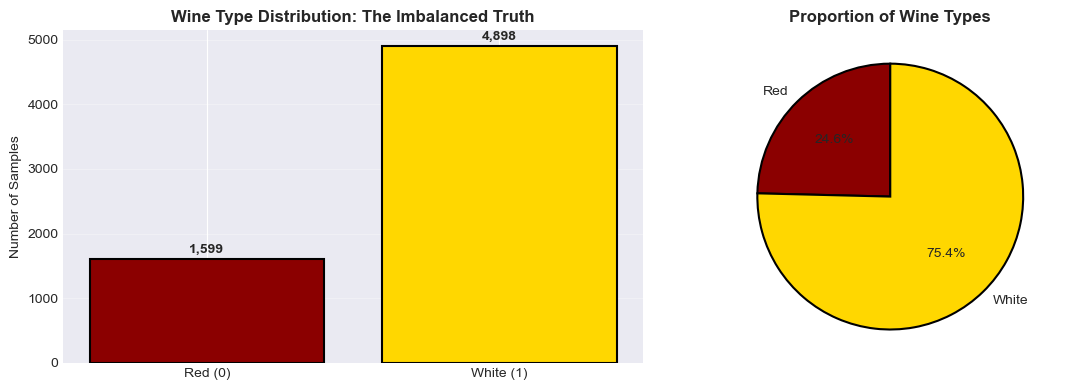

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Counts
wine_counts = wine_data["wine_type"].value_counts().sort_index()  # 0=red, 1=white
labels = ["Red (0)", "White (1)"]
colors = ["#8B0000", "#FFD700"]  # Dark red and gold

# Bar chart (absolute counts)
bars = ax1.bar(labels, wine_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_title("Wine Type Distribution: The Imbalanced Truth", fontweight='bold')
ax1.set_ylabel("Number of Samples")
for b, v in zip(bars, wine_counts.values):
    ax1.text(b.get_x() + b.get_width()/2, v + 50, f"{v:,}", ha="center", va="bottom", fontweight='bold')
ax1.grid(True, axis='y', alpha=0.3)

# Pie chart (proportions)
ax2.pie(
    wine_counts.values,
    labels=["Red", "White"],
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)
ax2.set_title("Proportion of Wine Types", fontweight='bold')

plt.tight_layout()
plt.show()

Whites are ~3× more frequent than reds (≈75% vs 25%).  
This imbalance means accuracy alone can mislead; I'll report macro-F1 and class-wise metrics later.  
When splitting the data, I'll use stratification to preserve these proportions.

## 6. Success Metrics Definition

**Primary metrics.** Accuracy (for intuition) + **macro-F1** (class balance) with confusion matrix.  
**Baselines.** Majority-class accuracy ≈ **75.4%** → any useful model must beat this comfortably.  
**Target.** ≥ **95%** accuracy / high macro-F1 is realistic given separability of chemistry features (validated in literature and prior student work).  
**Risks & guardrails.** The dataset is region-specific → possible **geographic bias**.  
Chemistry ≠ taste; avoid overclaiming. Document model limits; if deployed, monitor drift and re-validate on diverse regions/vintages.

See **Notebook 02** for detailed EDA (feature distributions, overlap) and preprocessing notes; no model training there yet.

## 7. Ethical & Regulatory Considerations

### Ethical Assessment
- **Risk Level**: Low (no personal data, no high-stakes decisions)
- **Bias Concerns**: Geographic bias (Portuguese wines only)
- **Transparency**: Model should be interpretable for quality control

### Sustainability Note
- Automated classification reduces manual testing waste
- Enables better inventory management, reducing spoilage

## 8. Dataset Alignment Statement

The UCI Wine Quality dataset aligns well with our classification objectives. It provides 11 physicochemical features that are objectively measurable and directly relevant to distinguishing wine types. The moderate class imbalance (25% red, 75% white) reflects real-world production ratios and is manageable with appropriate techniques.

**Strengths**: Clean data, expert-validated labels, interpretable features
**Limitations**: Geographic constraint (Portuguese wines), no temporal information
**Mitigation**: Acknowledge scope limitations, test on diverse wine samples if deployed

## 9. Next Steps

1. **Data Understanding**: Deep dive into feature distributions and relationships
2. **Preprocessing Pipeline**: Scaling, handling outliers, feature engineering
3. **Model Development**: Baseline models, then complexity escalation
4. **Evaluation Framework**: Cross-validation setup, metric tracking

In [31]:
# Save processed dataset for next notebooks
wine_data.to_csv('../data/wine_combined.csv', index=False)
print("✓ Combined dataset saved to data/wine_combined.csv")

✓ Combined dataset saved to data/wine_combined.csv


## Key Takeaways

- Binary classification problem with clear chemical distinctions
- Moderate class imbalance requires careful metric selection
- High interpretability needed for quality control applications
- Baseline performance to beat: 75.4% (majority class)